# Elliptical Data

Exploring (hopefully) more tractable non-Gaussian distributions.

In [1]:
import jax
from localization import datasets
import matplotlib.pyplot as plt
from localization.utils import build_gaussian_covariance

config_ = dict(
  # data config
  num_dimensions=40,
  xi1=5,
  xi2=5,
  df=5,
  batch_size=1000,
  support=(-1, 1),
  class_proportion=0.5,
  # experiment config
  seed=0,
)

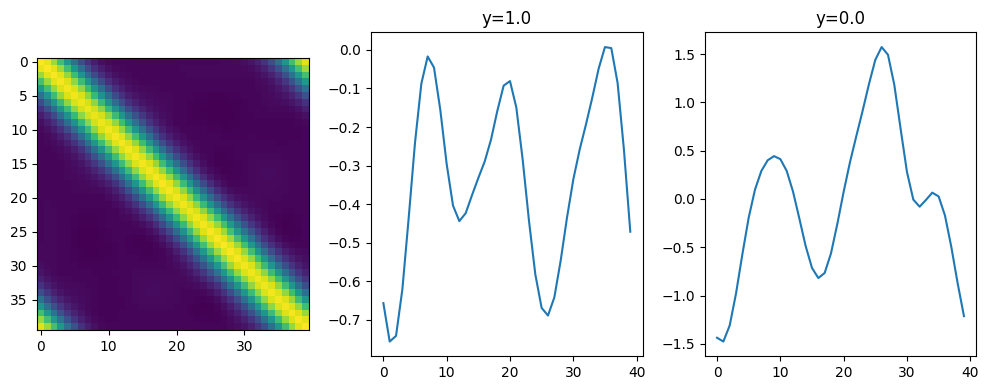

In [2]:
dataset = datasets.TDataset(key=jax.random.PRNGKey(0), **config_, num_exemplars=100000)
x, y = dataset[:100000]
xx = x.T @ x / len(x)
fig, axs = plt.subplots(1, 3, figsize=(10, 4))
axs[0].imshow(xx)
axs[1].plot(x[0])
axs[1].set_title(f'y={y[0]}')
axs[2].plot(x[1])
axs[2].set_title(f'y={y[1]}')
fig.tight_layout()

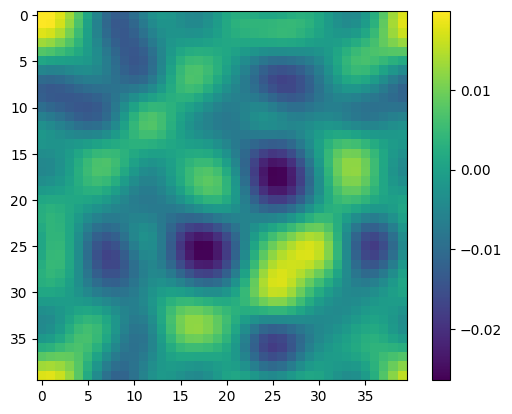

In [3]:
im = plt.imshow(xx - build_gaussian_covariance(40, 5))
plt.colorbar(im)

### Learning from t-data

In [63]:
import os
import numpy as np
import jax
import jax.numpy as jnp
import optax
import matplotlib.pyplot as plt
from localization import datasets
from localization import models
from localization import samplers
from localization.experiments import simulate, simulate_or_load, make_key
from localization.utils import plot_receptive_fields, plot_rf_evolution, build_gaussian_covariance, build_non_gaussian_covariance, entropy_sort

config_ = dict(
  # data config
  num_dimensions=40,
  dataset_cls=datasets.TDataset,
  batch_size=1000,
  support=(-1, 1),
  class_proportion=0.5,
  # model config
  model_cls=models.SimpleNet,
  activation='sigmoid',
  # activation='relu',
  use_bias=True,
  # use_bias=False,
  sampler_cls=samplers.EpochSampler,
  init_fn=models.xavier_normal_init,
  init_scale=1.,
  optimizer_fn=optax.sgd,
  # experiment config
  seed=0,
  save_=True,
  evaluation_interval=100,
)

Already simulated
Already simulated


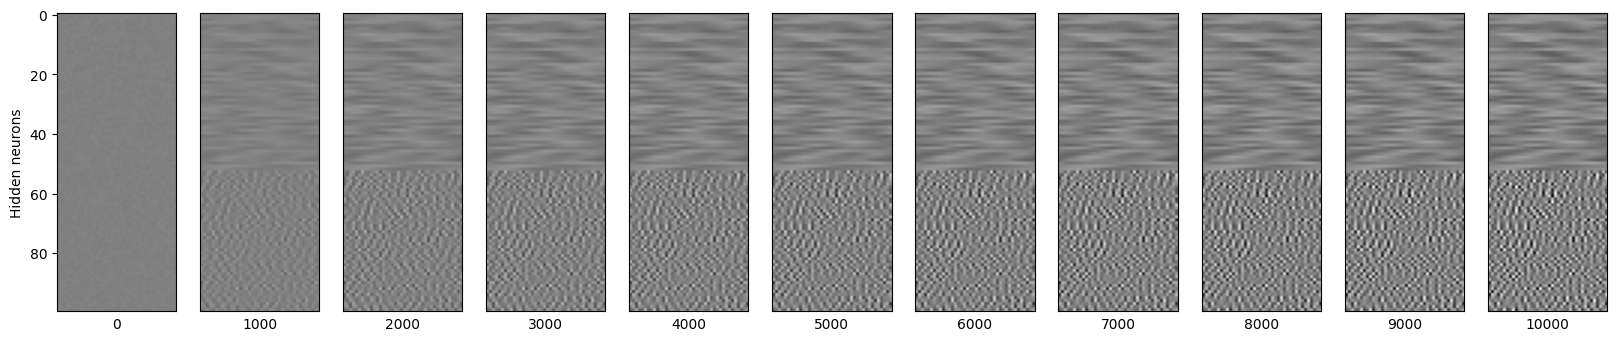

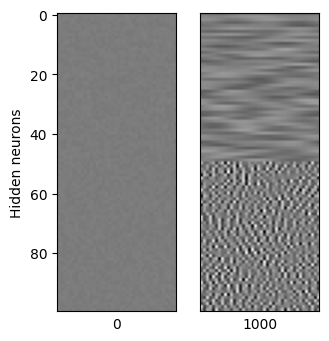

In [66]:
config = config_.copy()
config.update(dict(
    # num_hiddens=40, learning_rate=1, num_epochs=10000, 
    df=3,
    # gain=3, 
    num_hiddens=100, learning_rate=50, num_epochs=10000, 
))

low, metrics = simulate_or_load(xi1=2, xi2=1, **config)
fig, axs = plot_receptive_fields(low[::10], num_cols=11, evaluation_interval=1000, figsize=(20, 10), reordering_fn=entropy_sort, ind=-1)

osc, metrics = simulate_or_load(xi1=1, xi2=2, **config)
fig, axs = plot_receptive_fields(osc[[0,-1]], num_cols=11, evaluation_interval=1000, figsize=(20, 10), reordering_fn=entropy_sort, ind=-1)

# fig, axs = plot_rf_evolution(weights, cmap='gray', figsize=(10, 5))

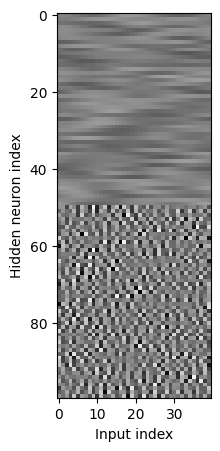

In [88]:
# fig, axs = plot_receptive_fields(osc[[-1]], num_cols=11, evaluation_interval=1000, figsize=(20, 20), reordering_fn=entropy_sort, ind=-1)
fig, axs = plt.subplots(1, 1, figsize=(10, 5))
w = osc[-1]
u = np.abs(np.fft.fft(w)).sum(1)
w = np.concatenate([w[u < 150], w[u > 150]])
axs.imshow(w, cmap='gray')
axs.set_xlabel('Input index')
axs.set_ylabel('Hidden neuron index')
axs.set_xticks([0, 10, 20, 30])
fig.savefig('t_dist_rf.png', dpi=300)

#### Tiling

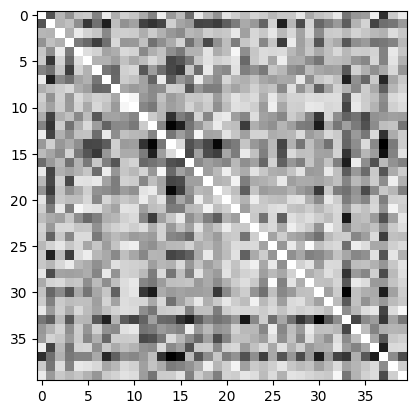

In [37]:
u = np.stack([ np.fft.fft(w) for w in weights ])
u = np.abs(u)
def cosine_sim(u, v):
  return u @ v / (np.linalg.norm(u) * np.linalg.norm(v))
inner = np.array([ [[cosine_sim(a,b) for a in u_] for b in u_] for u_ in u ])#.reshape(weights.shape[0], -1)
# _ = plt.plot(inner[-1])
_ = plt.imshow(inner[-1], cmap='gray')

### Not localized

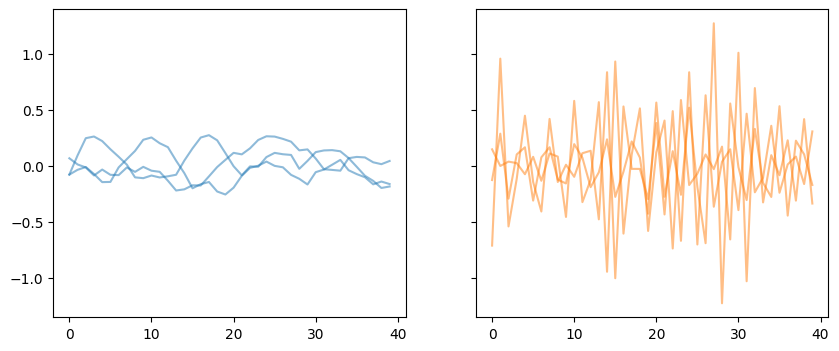

In [62]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
_ = ax1.plot(low[-1,:3].T, color='tab:blue', alpha=0.5)
_ = ax2.plot(osc[-1,:3].T, color='tab:orange', alpha=0.5)

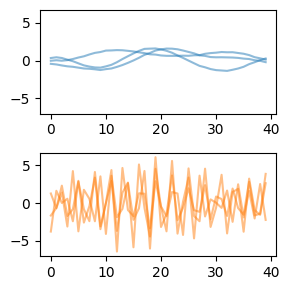

In [95]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(3, 3), sharey=True)
_ = ax1.plot(w[:3].T, color='tab:blue', alpha=0.5)
_ = ax2.plot(w[-3:].T, color='tab:orange', alpha=0.5)
ax1.
fig.tight_layout()

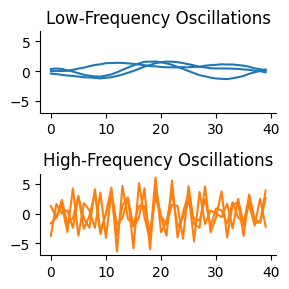

In [98]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(3, 3), sharey=True)
ax1.plot( w[:3].T, label='Localized', color='tab:blue' )
ax2.plot( w[-3:].T, label='Oscillatory', color='tab:orange' )
ax1.set_title('Low-Frequency Oscillations')
ax2.set_title('High-Frequency Oscillations')

for ax in (ax1, ax2):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
fig.tight_layout()
fig.savefig('t_dist_rf_individual.png', dpi=300)

#### No localization

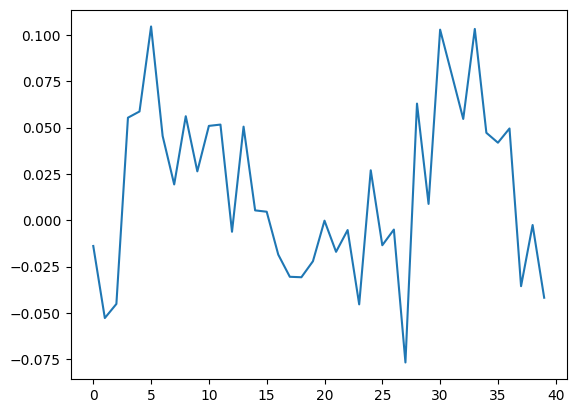

In [21]:
_ = plt.plot(weights[1,0])

In [21]:
weights[5,0]

array([ 0.03806078, -0.00640856, -0.01530846,  0.07371872,  0.00938829,
        0.08136344, -0.03610664, -0.05248559,  0.07087168, -0.04579896,
       -0.01423462,  0.02909311, -0.09117647,  0.07759472,  0.01522831,
        0.00924608,  0.02950739, -0.00941721, -0.03372172,  0.01579539,
       -0.04932225,  0.05721361, -0.02128004, -0.05984038,  0.03204441,
       -0.01404464,  0.02255496, -0.09093183,  0.09907813, -0.07155968,
        0.03930189,  0.15226614,  0.19591127,  0.20770435,  0.06101864,
        0.00239856,  0.0160922 , -0.06115257,  0.03246481, -0.05865391],
      dtype=float32)